### Import all the required libraries

In [5]:
#!pip install html5lib
#!pip install lxml
#!pip install beautifulSoup4

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import html5lib
import lxml
import requests
import keras
from bs4 import BeautifulSoup
import ast
from pandas.io.json import json_normalize

Using TensorFlow backend.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jupyterlab/con

##### loading the parking data obtained from kaggle

In [46]:
df=pd.read_csv('Searching_for_parking_NA.csv')

### Webscraping from wikipedia

In [47]:
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_North_American_cities_by_population')
tabs=table[0]

##### Cleaning the webscraped data

In [48]:
#removing the references from the population column
new = tabs['Population'].str.split("[", n = 1, expand = True) 
tabs["pop"]= new[0] 

In [49]:
#removing commas in the population column
tabs['pop']=tabs['pop'].apply(lambda x: float(x.split()[0].replace(",","")))

In [50]:
#for further merges or join New York city has to be edited 
tabs["City"]= tabs["City"].replace('New York City', "New York") 

### Webscraping GDP data 

In [51]:
sable = pd.read_html('https://en.wikipedia.org/wiki/List_of_cities_by_GDP_(PPP)_per_capita')
sabs=sable[0]
sabs.columns=['Metro_ID','City','GDP_per_capita']

##### Cleaning the GDP data

In [52]:
# removing references or brackets from the column
new = sabs['City'].str.split("(", n = 1, expand = True) 
sabs["City"]= new[0] 
#removing white spaces from the end of the data
sabs['City']=sabs['City'].str.rstrip()

##### Cleaning the original kaggle data since SearchingByHour and HourlyDistribution are in json object formats

In [53]:
#converting null to 0 for the selected columns
df['SearchingByHour']=df['SearchingByHour'].str.replace("null","0")
df['HourlyDistribution']=df['HourlyDistribution'].str.replace("null","0")

In [54]:
#converting the columns to string
df['SearchingByHour']=df['SearchingByHour'].apply(ast.literal_eval)
df['HourlyDistribution']=df['HourlyDistribution'].apply(ast.literal_eval)

In [55]:
#putting the JSON object into a workable format for pandas
dict_cols = pd.DataFrame(json_normalize(df["SearchingByHour"]).stack()).reset_index(level=1)
dict_cols.columns = ['hours_1','search_values']

dict_cols2 = pd.DataFrame(json_normalize(df["HourlyDistribution"]).stack()).reset_index(level=1)
dict_cols2.columns = ['hours','hd_values']

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


In [56]:
#joining the columns to the df database
search = pd.concat([df, dict_cols], axis=1)
search2=pd.concat([search,dict_cols2],axis=1)

##### merging the kaggle data and the webscraped data into one dataframe

In [64]:
#joining the cleaned kaggle columns to the population data
allin=pd.merge(search2, tabs, how='left', on='City')
allin=allin.drop(['Image','Country_y','Population','Year'],axis=1)
allin=allin.dropna()

In [66]:
#joining the kaggle + population columns to the GDP per capita data
allin2=pd.merge(allin, sabs, how='left', left_on='City', right_on='City')
allin3=allin2.dropna()

In [68]:
allin3=allin3.drop(['Version','Latitude_SW','Longitude_SW','Latitude_NE','Longitude_NE'],axis=1)
allin3=allin3.drop(['Country_x','PercentOther','UpdateDate','Metro_ID','GeohashBounds','Location'],axis=1)
allin3=allin3.drop(['Geohash','ISO_3166_2','City','County','State','CirclingDistribution','HourlyDistribution','SearchingByHour'],axis=1)
allin3=allin3.drop(['hours_1','Unnamed: 0','Latitude','Longitude'],axis=1)

### Feature Engineering
One hot encoding the hours column

In [69]:
from sklearn.preprocessing import OneHotEncoder
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(allin3[['hours']]).toarray())
# merge with main df bridge_df on key values
allin3 = allin3.join(enc_df)

In [70]:
allin3=allin3.drop(['hours'],axis=1)

In [71]:
#Dropping the avgtotalgeohashes to see the effect on the data 

In [72]:
allin3=allin3.dropna()

### Data Exploration

##### Boxplot for the average time to park for each city 

##### New York and Boston have the highest average time to park times at about 7 mins
##### The lowest time is Vancouver at about 2 mins

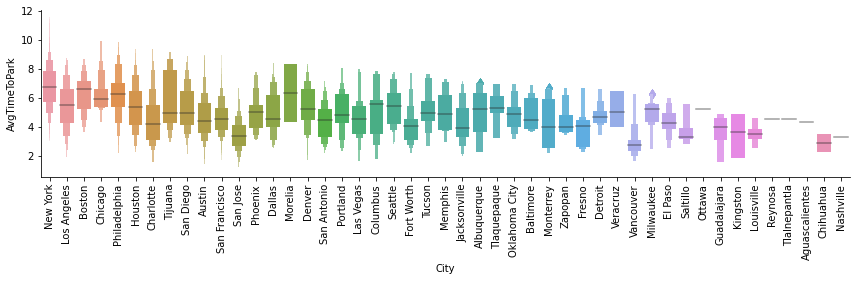

<Figure size 432x288 with 0 Axes>

In [29]:
sns.catplot(y = "AvgTimeToPark", x = "City", data = allin2.sort_values("AvgTimeToPark", ascending = False), kind="boxen", height = 4, aspect = 3)

#g.set_xticklabels(rotation=90)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
plt.savefig('boxplotforcitiesavgpark.png')

#### Distribution plot for the average time to park for the data set 

#### the distribution plot is fairly normal with a peak of 4.5mins. It is also slightly skewed to the left. 

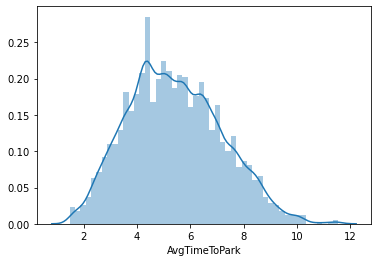

In [30]:
sns.distplot(a=allin3['AvgTimeToPark'])
plt.savefig('distributionavgpark.png')

#### Correlation heat map for the correlation plot for the features used in the model

In [31]:
parkcolumns=allin3.columns

In [32]:
parkcolumns2 = allin3[[ 'AvgTimeToPark', 'AvgTimeToParkRatio',     'TotalSearching',
         'PercentSearching', 'AvgUniqueGeohashes',         'PercentCar',
               'PercentMPV',         'PercentLDT',         'PercentMDT',
               'PercentHDT',      'search_values',          'hd_values',
                      'pop',     'GDP_per_capita']]

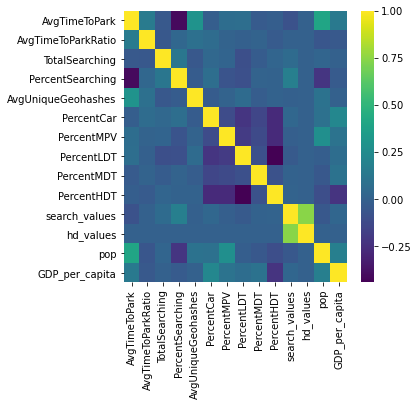

In [33]:

fig = plt.figure(figsize= (5,5))
sns.heatmap(parkcolumns2.corr(), annot=False, vmax=1, cmap='viridis', square=False)
plt.savefig('correlationplot.png')

In [ ]:
#decision to drop #avgtotalGeohashes

In [73]:
allin3=allin3.drop(['AvgTotalGeohashes'],axis=1)

In [74]:
allin3=allin3.dropna()

In [ ]:
X.head

## Regression Analysis

### Linear Regression

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [76]:
X=allin3.drop(['AvgTimeToPark'],axis=1)
y=allin3.AvgTimeToPark

In [77]:
#from sklearn import preprocessing
#X = preprocessing.scale(X) 

In [78]:
# Create a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [79]:
#Transform data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [80]:
#Default linear regression

In [81]:
model = LinearRegression()
model.fit(X_train, y_train)

print(f"R^2 score on training set: {model.score(X_train, y_train):0.3f}")
print(f"R^2 score on test set: {model.score(X_test, y_test):0.3f}")

R^2 score on training set: 0.381
R^2 score on test set: 0.378


In [83]:
#defining the coefficients of the dataset
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])

In [84]:
coeff1=coeff_df.sort_values(by=['Coefficient'], ascending=False)

#### the most postive coefficients

In [90]:
coeff1.head()

,Coefficient
19,9.937007e+12
21,9.920106e+12
13,9.911643e+12
4,9.869197e+12
11,9.864940e+12


#### the most negative coefficients

In [91]:
coeff1.tail()

,Coefficient
search_values,-0.006311
PercentMDT,-0.048918
PercentCar,-0.102884
PercentMPV,-0.109346
PercentSearching,-0.611876


In [92]:
y_pred = model.predict(X_test)

In [93]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.0999952266057724
Mean Squared Error: 1.9031085197453232
Root Mean Squared Error: 1.3795319930126024


#### Hyper paramter tuning the linear regression to obtain the best linear model

In [94]:
from sklearn.model_selection import RandomizedSearchCV

In [95]:
from sklearn.model_selection import cross_val_score
# function to get cross validation scores
def get_cv_scores(model):
    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             cv=5,
                             scoring='r2')
    
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')

In [96]:
from sklearn.linear_model import ElasticNet
# Train model with default alpha=1 and l1_ratio=0.5
elastic_net = ElasticNet(alpha=1, l1_ratio=0.5).fit(X_train, y_train)

In [97]:
#### the main hyperparameter run for the linear regression

In [98]:
# find optimal alpha with randomized search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
l1_ratio = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
param_grid = dict(alpha=alpha, l1_ratio=l1_ratio)
grid = RandomizedSearchCV(estimator=elastic_net, param_distributions=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

Best Score:  0.37859827563219656
Best Params:  {'l1_ratio': 0.5, 'alpha': 0.001}


### Decision Tree Regression

#### Initial Decision tree regressor

In [40]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from scipy.stats import randint

In [41]:
DTmodel = DecisionTreeRegressor()
DTmodel.fit(X_train, y_train)

print(f"R^2 score on training set: {DTmodel.score(X_train, y_train):0.3f}")
print(f"R^2 score on test set: {DTmodel.score(X_test, y_test):0.3f}")

R^2 score on training set: 1.000
R^2 score on test set: 1.000


#### Optimized decision tree regression

In [44]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ['mse','mae']}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeRegressor()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'mse', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 2}
Best score is 0.9162681049545995


In [45]:
y_preds = tree_cv.predict(X_test)

In [46]:
 #Computing r2_score
from sklearn.metrics import r2_score
r2_score(y_test,y_preds)

0.9457117444813177

In [47]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_preds))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_preds))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_preds)))

Mean Absolute Error: 0.08745094329767604
Mean Squared Error: 0.15545613971836106
Root Mean Squared Error: 0.3942792661532699


### Feature importance for the Decision tree model

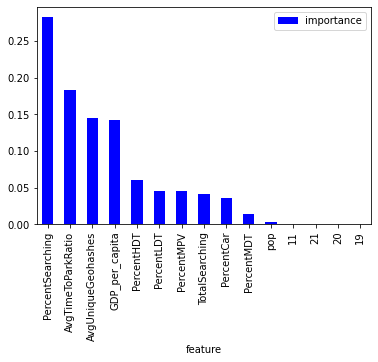

In [70]:
importances = DTmodel.feature_importances_
feat_names = X.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result.sort_values(by='importance',ascending=False)[:15].plot(x='feature', y='importance', kind='bar',color='blue')
plt.savefig('decisontreeimportantfeatures.png')

#### initial random forest regressor

In [66]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing, svm
from sklearn.model_selection import cross_validate

In [67]:
#fitting the initial random forest regressor to the training data
clf = RandomForestRegressor()
clf.fit(X_train, y_train)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [51]:
r2_score = clf.score(X_test, y_test)

In [52]:
print(r2_score)

1.0


In [53]:
y_preda = clf.predict(X_test)

In [54]:
 #Computing r2_score
from sklearn.metrics import r2_score
r2_score(y_test,y_preda)

1.0

In [55]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 5.970242942824877e-16
Mean Squared Error: 7.412115887982661e-31
Root Mean Squared Error: 8.60936460372231e-16


#### Another Random Forest Regressor using RandomizedsearchCV

In [56]:
random_grid = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ['mse','mae']}

In [57]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
clf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
clf_random.fit(X_train, y_train)
clf_random.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=7 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=7, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=7 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=7, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=7, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=7 
[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=7, total=   0.1s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=7, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=5, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=5 
[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=5, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=5, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=5, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=5, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7 
[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=8, min_samples_leaf=5 ..
[CV]  criterion=mse, max_depth=3, max_features=8, min_samples_leaf=5, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=8, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=8, min_samples_leaf=5, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=8, min_samples_leaf=5 ..
[CV]  criterion=mse, max_depth=3, max_features=8, min_samples_leaf=5, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=8, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=8, min_samples_leaf=5, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=8, min_samples_leaf=5 ..
[CV]  criterion=mse, max_depth=3, max_features=8, min_samples_leaf=5, total=   0.1s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=3, total=   9.9s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=3, total=   8.2s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=3, total=  10.7s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=3, total=   8.6s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=3, total=   8.8s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=8, total=   2.3s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=8, total=   2.4s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=8, total=   2.3s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=8, total=   2.3s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=8, total=   2.1s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=2, total=   7.0s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=2, total=   7.2s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=2, total=   7.8s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=2, total=   8.7s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=2, total=   8.4s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=1, total=   6.4s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=1, total=   7.2s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=1, total=   6.9s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=1, total=   6.6s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=1, total=   7.1s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5, total=   6.8s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5, total=   7.4s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5, total=   8.0s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5, total=   7.5s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5, total=   7.3s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3, total=   1.9s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3, total=   1.8s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3, total=   1.9s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3, total=   1.8s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3, total=   2.0s
[CV] criterion=mse, max_depth=3, max_features=2, min_samples_leaf=8 ..
[CV]  criterion=mse, max_depth=3, max_features=2, min_samples_leaf=8, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=2, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=2, min_samples_leaf=8, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=2, min_samples_leaf=8 ..
[CV]  criterion=mse, max_depth=3, max_features=2, min_samples_leaf=8, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=2, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=2, min_samples_leaf=8, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=2, min_samples_leaf=8 ..
[CV]  criterion=mse, max_depth=3, max_features=2, min_samples_leaf=8, total=   0.1s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7, total=   8.0s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7, total=   7.8s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7, total=   8.6s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7, total=   8.0s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7, total=  11.7s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=6, total=   7.4s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=6, total=   6.9s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=6, total=   8.5s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=6, total=   7.5s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=6, total=   7.2s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=4, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=4, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=4, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=4, total=   0.3s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=5, total=   2.8s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=5, total=   2.9s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=5, total=   2.9s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=5, total=   3.0s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=5, total=   2.6s
[CV] criterion=mse, max_depth=3, max_features=5, min_samples_leaf=1 ..
[CV]  criterion=mse, max_depth=3, max_features=5, min_samples_leaf=1, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=5, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=5, min_samples_leaf=1, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=5, min_samples_leaf=1 ..
[CV]  criterion=mse, max_depth=3, max_features=5, min_samples_leaf=1, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=5, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=5, min_samples_leaf=1, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=5, min_samples_leaf=1 ..
[CV]  criterion=mse, max_depth=3, max_features=5, min_samples_leaf=1, total=   0.1s
[CV] criterion=mse, max_depth=None, max_features=4, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=4, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=4, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=4, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=4, min_samples_leaf=1 
[CV]  criterion=mse, max_depth=None, max_features=4, min_samples_leaf=1, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=4, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=4, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=4, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=4, min_samples_leaf=1, total=   0.3s
[CV] criterion=mae, max_depth=None, max_features=2, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=2, min_samples_leaf=2, total=   5.4s
[CV] criterion=mae, max_depth=None, max_features=2, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=2, min_samples_leaf=2, total=   5.7s
[CV] criterion=mae, max_depth=None, max_features=2, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=2, min_samples_leaf=2, total=   4.9s
[CV] criterion=mae, max_depth=None, max_features=2, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=2, min_samples_leaf=2, total=   4.8s
[CV] criterion=mae, max_depth=None, max_features=2, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=2, min_samples_leaf=2, total=   4.9s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=2, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=2, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=2, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=2, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=2, total=   0.3s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4, total=   7.7s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4, total=   7.1s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4, total=   9.4s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4, total=   8.4s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4, total=   8.0s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=8 
[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=8, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=8 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=8, total=   0.4s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=8 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=8, total=   0.5s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=8 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=8, total=   0.5s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=8 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=8, total=   0.5s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1, total=   0.1s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=4, total=   8.9s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=4, total=   8.6s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=4, total=   8.3s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=4, total=   8.6s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=4, total=   8.5s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=6, total=   6.6s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=6, total=   6.8s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=6, total=   9.2s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=6, total=   6.4s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=6, total=   7.1s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5, total=   6.6s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5, total=   7.5s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5, total=   7.9s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5, total=   6.8s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5, total=   7.2s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4 
[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4 
[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4, total=   0.2s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=4, total=   6.9s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=4, total=   8.8s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=4, total=   6.8s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=4, total=   7.1s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=4, total=   7.4s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.5s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.3s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.1s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.4s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.3s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4, total=   7.8s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4, total=   9.5s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4, total=   7.9s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4, total=   8.0s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4, total=   7.9s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5, total=   0.3s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=7, total=   3.8s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=7, total=   2.1s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=7, total=   2.3s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=7, total=   2.3s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=7, total=   2.3s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=1, total=   0.2s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5, total=   5.3s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5, total=   5.9s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5, total=   5.8s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5, total=   7.4s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5, total=   5.8s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=5 ..
[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=5, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=5 ..
[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=5, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=5, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=5 ..
[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=5, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=5, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=1 ..
[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=1, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=1, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=1 ..
[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=1, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=1 ..
[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=1, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=1, total=   0.2s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=8, total=   3.1s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=8, total=   3.2s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=8, total=   3.5s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=8, total=   3.5s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=8, total=   3.1s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=3, total=   2.5s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=3, total=   2.9s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=3, total=   3.3s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=3, total=   2.8s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=3, total=   2.6s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=3 
[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=3, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=3, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=3, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=3, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=5, min_samples_leaf=2 ..
[CV]  criterion=mse, max_depth=3, max_features=5, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=5, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=5, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=5, min_samples_leaf=2 ..
[CV]  criterion=mse, max_depth=3, max_features=5, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=5, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=5, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=5, min_samples_leaf=2 ..
[CV]  criterion=mse, max_depth=3, max_features=5, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=4 
[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=8, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=8, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=8, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=8, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=8, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=8, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=8, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=8, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=8, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=8, min_samples_leaf=4, total=   0.1s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.1s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.3s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.0s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.3s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.5s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=6, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=6, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=6, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=6, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=6, total=   0.3s
[CV] criterion=mse, max_depth=3, max_features=1, min_samples_leaf=3 ..
[CV]  criterion=mse, max_depth=3, max_features=1, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=1, min_samples_leaf=3 ..
[CV]  criterion=mse, max_depth=3, max_features=1, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=1, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarni

[CV]  criterion=mse, max_depth=3, max_features=1, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=1, min_samples_leaf=3 ..
[CV]  criterion=mse, max_depth=3, max_features=1, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=1, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=1, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=3 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=3 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=3 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=2, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=2, min_samples_leaf=7, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=2, min_samples_leaf=7 ..
[CV]  criterion=mse, max_depth=3, max_features=2, min_samples_leaf=7, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=2, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=2, min_samples_leaf=7, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=2, min_samples_leaf=7 ..
[CV]  criterion=mse, max_depth=3, max_features=2, min_samples_leaf=7, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=2, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=2, min_samples_leaf=7, total=   0.1s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=3 
[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=3, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=3, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=3, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=3, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=3, total=   0.3s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=2 ..
[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=2 ..
[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=2 ..
[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=2, total=   0.1s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=3, total=   6.8s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=3, total=   7.6s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=3, total=   7.0s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=3, total=   6.4s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=3, total=   6.2s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=1, total=   0.3s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=4, total=   5.3s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=4, total=   5.7s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=4, total=   4.9s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=4, total=   5.0s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=4, total=   5.1s
[CV] criterion=mae, max_depth=3, max_features=7, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=7, min_samples_leaf=7, total=   5.0s
[CV] criterion=mae, max_depth=3, max_features=7, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=7, min_samples_leaf=7, total=   4.7s
[CV] criterion=mae, max_depth=3, max_features=7, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=7, min_samples_leaf=7, total=   4.5s
[CV] criterion=mae, max_depth=3, max_features=7, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=7, min_samples_leaf=7, total=   4.5s
[CV] criterion=mae, max_depth=3, max_features=7, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=7, min_samples_leaf=7, total=   5.2s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=5 ..
[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=5, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=5, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=5 ..
[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=5, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=5, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=5 ..
[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=5, total=   0.1s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.1s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.7s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.4s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.4s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   4.8s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4, total=   0.1s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=6, total=   6.5s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=6, total=   6.3s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=6, total=   6.5s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=6, total=   7.6s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=6, total=   7.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4, total=   0.1s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=4, total=   6.3s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=4, total=   6.4s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=4, total=   6.1s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=4, total=   7.5s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=4, total=   6.4s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=8 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=8, total=   4.7s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=8 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=8, total=   4.8s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=8 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=8, total=   4.9s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=8 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=8, total=   4.8s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=8 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=8, total=   5.1s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1, total=   3.2s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1, total=   3.1s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1, total=   3.6s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1, total=   3.3s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1, total=   3.2s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1, total=   0.1s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3, total=   1.9s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3, total=   1.7s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3, total=   1.9s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3, total=   1.8s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3, total=   1.8s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=3, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=3, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=3, total=   0.5s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=3, total=   0.6s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=3, total=   0.6s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=1, total=   0.6s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=1, total=   0.5s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=1, total=   0.4s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=4, min_samples_leaf=8 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=4, min_samples_leaf=8, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=4, min_samples_leaf=8 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=4, min_samples_leaf=8, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=4, min_samples_leaf=8 
[CV]  criterion=mse, max_depth=None, max_features=4, min_samples_leaf=8, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=4, min_samples_leaf=8 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=4, min_samples_leaf=8, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=4, min_samples_leaf=8 
[CV]  criterion=mse, max_depth=None, max_features=4, min_samples_leaf=8, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=8 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=8, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=8, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=8 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=8, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=8, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=8 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=8, total=   0.1s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4, total=   3.5s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4, total=   3.8s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4, total=   3.5s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4, total=   3.7s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4, total=   3.7s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=2, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=2, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=2 
[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=2, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=2, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=2, total=   0.2s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=7, total=   9.4s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=7, total=   7.1s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=7, total=   6.6s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=7, total=   6.6s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=7, total=   6.8s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=5, total=   1.7s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=5, total=   3.3s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=5, total=   2.3s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=5, total=   1.8s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=5, total=   1.8s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=3 
[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=3, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=3, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=3 
[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=3, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=3, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=3 
[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4 
[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4, total=   0.2s
[CV] criterion=mae, max_depth=3, max_features=5, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=5, min_samples_leaf=8, total=   3.6s
[CV] criterion=mae, max_depth=3, max_features=5, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=5, min_samples_leaf=8, total=   3.9s
[CV] criterion=mae, max_depth=3, max_features=5, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=5, min_samples_leaf=8, total=   3.7s
[CV] criterion=mae, max_depth=3, max_features=5, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=5, min_samples_leaf=8, total=   3.9s
[CV] criterion=mae, max_depth=3, max_features=5, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=5, min_samples_leaf=8, total=   4.0s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=6 ..
[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=6, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=6 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=6, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=6 ..
[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=6, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=6 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=6, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=6 ..
[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=6, total=   0.1s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2, total=   3.4s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2, total=   3.6s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2, total=   3.2s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2, total=   3.2s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2, total=   3.2s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7, total=   8.7s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7, total=   7.8s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7, total=  10.8s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7, total=   8.1s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7, total=   7.8s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=8, total=   4.1s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=8, total=   3.8s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=8, total=   2.9s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=8, total=   2.8s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=8, total=   2.8s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=6 ..
[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=6, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=6 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=6, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=6 ..
[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=6, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=6 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=6, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=6 ..
[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=6, total=   0.2s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2, total=   3.4s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2, total=   3.1s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2, total=   3.3s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2, total=   3.3s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2, total=   3.3s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=7, total=   4.8s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=7, total=   7.1s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=7, total=   4.9s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=7, total=   5.0s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=7, total=   5.1s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=1, total=   4.4s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=1, total=   4.6s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=1, total=   4.4s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=1, total=   4.6s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=1, total=   3.6s
[CV] criterion=mae, max_depth=3, max_features=6, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=6, min_samples_leaf=8, total=   4.0s
[CV] criterion=mae, max_depth=3, max_features=6, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=6, min_samples_leaf=8, total=   4.6s
[CV] criterion=mae, max_depth=3, max_features=6, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=6, min_samples_leaf=8, total=   4.4s
[CV] criterion=mae, max_depth=3, max_features=6, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=6, min_samples_leaf=8, total=   3.9s
[CV] criterion=mae, max_depth=3, max_features=6, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=6, min_samples_leaf=8, total=   3.9s
[CV] criterion=mse, max_depth=3, max_features=4, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=4, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=4, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=4, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=4, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=4, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=4, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=4, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=4, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=4, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=2, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=2, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=2, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=2, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=2, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=4, total=   0.1s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1, total=   3.3s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1, total=   3.1s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1, total=   3.1s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1, total=   3.3s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1, total=   3.5s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=7, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=7, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=7, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=7, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=7, total=   0.3s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=3, total=   3.7s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=3, total=   7.3s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=3, total=   3.9s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=3, total=   3.7s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=3, total=   3.7s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=2, total=   1.8s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=2, total=   1.8s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=2, total=   1.7s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=2, total=   1.7s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=2, total=   1.8s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=2 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=2, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=2 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=2 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=4, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=4, min_samples_leaf=8, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=4, min_samples_leaf=8 ..
[CV]  criterion=mse, max_depth=3, max_features=4, min_samples_leaf=8, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=4, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=4, min_samples_leaf=8, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=4, min_samples_leaf=8 ..
[CV]  criterion=mse, max_depth=3, max_features=4, min_samples_leaf=8, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=4, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=4, min_samples_leaf=8, total=   0.1s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4, total=   3.6s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4, total=   3.7s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4, total=   3.6s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4, total=   4.1s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4, total=   3.9s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=1, total=   2.1s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=1, total=   2.3s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=1, total=   2.2s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=1, total=   2.1s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=1, total=   2.3s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5, total=   5.8s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5, total=   5.6s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5, total=   5.8s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5, total=   6.0s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5, total=   5.5s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7 
[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7 
[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7, total=   0.2s


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7 
[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7, total=   0.2s

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=3 ..
[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=3 ..
[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=3 ..
[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=3, total=   0.1s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=4, total=   5.5s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=4, total=   5.7s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=4, total=   5.5s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=4, total=   4.5s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=4, total=   5.2s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=1, total=   7.8s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=1, total=  11.2s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=1, total=   9.2s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=1, total=   8.8s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=1, total=   8.9s


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 22.9min finished
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'criterion': 'mae',
 'max_depth': None,
 'max_features': 8,
 'min_samples_leaf': 1}

In [58]:
ans = clf_random.predict(X_test)

In [59]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy


In [60]:
best_random = clf_random.best_estimator_
random_accuracy = evaluate(best_random,X_test, y_test)

Model Performance
Average Error: 0.0539 degrees.
Accuracy = 98.89%.


In [61]:
from sklearn.metrics import r2_score
r2_score(y_test, ans)


0.9935728712930098

In [62]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, ans))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, ans))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, ans)))

Mean Absolute Error: 0.053949244966443335
Mean Squared Error: 0.01840428668624161
Root Mean Squared Error: 0.1356623996774405


#### Feature importance based on the un optimized model

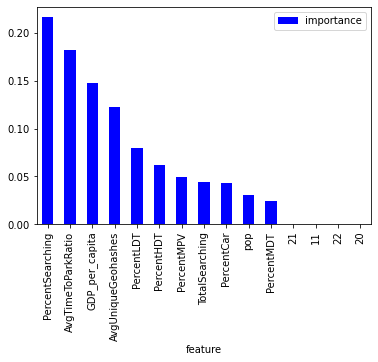

In [68]:
importances = clf.feature_importances_
feat_names = X.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result.sort_values(by='importance',ascending=False)[:15].plot(x='feature', y='importance', kind='bar',color='blue')
plt.savefig('decisontreeimportantfeatures.png')